In [1]:
import requests, json, regex, js2xml, re
from bs4 import BeautifulSoup, Comment

def get_crimes(data):
    crimes=["Anti-social behaviour","Bicycle theft","Burglary","Criminal damage and arson","Drugs","Other theft","Possession of weapons","Public order","Robbery","Shoplifting","Theft from the person","Vehicle crime","Violence and sexual offences","Other crime"]
    string = data[0]
    pattern= re.compile('\[[^)]+\]')
    string = string.strip()

    split = string.split('data: ',1)[1]
    raw_data= pattern.findall(split)[0]
    all_shit = []
    for i in raw_data.split('\n'):
        res = i.strip('][').split(', ')
        all_shit.append(res)

    numbers = []
    for i in all_shit:
        for word in i[-1].split('],'):
            if word.isdigit():
                numbers.append(int(word))

#     print(list(zip(crimes,numbers)))
#     print(sum(numbers))
    return list(zip(crimes,numbers)), sum(numbers)

def get_crime_data(postcode):
    postcode = postcode.replace(" ","%20")
    URL = 'https://www.crime-statistics.co.uk/postcode/'+postcode
    print("Getting Crime Data")
    page = requests.get(URL)
    pattern = regex.compile(r'\{(?:[^{}]|(?R))*\}')

    print("Parsing Response")
    soup = BeautifulSoup(page.content, 'html.parser')
    element = soup.find("div", id="divPieChart")
    script = element.find('script')

    print("Extracting Data")
    data = pattern.findall(str(script))

#     print ("getting crime statistics")
    return get_crimes(data)


In [2]:
import os
import glob
from difflib import SequenceMatcher
import Levenshtein

def get_maps(city):
    maps = []
    city = "results/"+city + "*"
    for file in glob.glob(city):
        maps.append(file)
    return maps


def get_closest(word, chimney=True):
    if chimney:
        p_chimney = Levenshtein.ratio(word, "chimney")
        p_chy = Levenshtein.ratio(word, "chy")
    else:
        return Levenshtein.ratio(word,"post")
        
    if p_chimney > p_chy:
        return p_chimney
    else:
        return p_chy

def get_locations(city, chimney=True):
    print("Getting Map Files")
    maps = get_maps(city)
    longs = []
    lats = []
#     word_file = open("words.txt", "a")
    print("Processing Map Files")
    for f in maps:
        ofile = open(f, 'r')
        for line in ofile:
            lat, long, blank, prob1, word, prob2,postcode = line.split(',')
            word=word.replace('"','')
            p_use = get_closest(word, chimney)
            if(p_use > 0.8):
                longs.append(long)
                lats.append(lat)
    locations = set(zip(longs,lats))
    return locations

def hit_api(location):
    long, lat = location
#     print(location)
    URL = 'http://api.postcodes.io/postcodes?lon='+long+'&lat='+lat
    page = requests.get(URL)
    json_obj = json.loads(page.content)
    return json_obj

def get_postcode(city):
    print("Getting Chimney Locations")
    locations = get_locations(city)
#     print(locations)
    postcodes = []
    print("Getting Postcodes from Lat/Long")
    for location in locations:
        
#         long, lat = location
#         URL = 'http://api.postcodes.io/postcodes?lon='+long+'&lat='+lat
#         page = requests.get(URL)
        json_obj = hit_api(location)
        if json_obj["result"]:
            pc = json_obj["result"][0]['postcode']
#             postcodes.append(pc)
            postcodes.append((pc, location))
    print("Returning Unique Postcodes")
    return set(postcodes)


In [3]:
def crimes_by_city(city):
    print("Getting Postcodes of Chimneys in: " + city)
    postcodes = get_postcode(city)
    for pc in postcodes:
#         print("Getting Crime Data")
        breakdown, total = get_crime_data(pc[0])
        print()
        print("###########################################")
        print("POSTCODE: "+pc[0])
        print("CRIME BREAKDOWN:" + str(breakdown))
        print()
        print("TOTAL CRIMES = "+str(total))
        print("############################################")

In [4]:
import csv

def accumulate_crime_data():
    crime_data = [['Longitude','Latitude','Crime Type']]
    for file in glob.glob("Crime-Data/2020-03*"):
        with open(file, newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            next(spamreader)
            for row in spamreader:
#                 print(row)
                if row[4] == "":
                    continue
                else:
#                     obj = hit_api((row[4],row[5]))
#                     if obj["result"]:
#                         pc = obj["result"][0]['postcode']
                    crime_data.append([row[4],row[5],row[9]])
                    
    return crime_data

# print(accumulate_crime_data())

def write_crime_to_file(crime_data):        
    with open('all-crimes-postcodes-march-2020.csv', mode='w') as employee_file:
        crime_writer = csv.writer(employee_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for row in crime_data:
            crime_writer.writerow(row)

            
def generate_crime_file():
    write_crime_to_file(accumulate_crime_data())

# generate_crime_file()


In [5]:
import csv

def get_crime_data(file):
    crimes = []
    with open(file, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        next(spamreader)
        for row in spamreader:
            crimes.append([row[0],row[1],row[2]])
    return crimes

data = get_crime_data("all-crimes.csv")

In [22]:
# print(data[1])
# postcodes = []
# counter = -1
# for row in data:
#     counter+=1
#     print(str(counter)+"/"+str(len(data)))
#     obj = hit_api((row[0],row[1]))
#     if obj["result"]:
#         pc = obj["result"][0]['postcode']
#         postcodes.append(pc)
# print(postcodes)

['-1.237805', '54.711196', 'Anti-social behaviour']
0/19329646
1/19329646
2/19329646
3/19329646
4/19329646
5/19329646
6/19329646
7/19329646
8/19329646
9/19329646
10/19329646
11/19329646
12/19329646
13/19329646
14/19329646
15/19329646
16/19329646
17/19329646
18/19329646
19/19329646
20/19329646
21/19329646
22/19329646
23/19329646
24/19329646
25/19329646
26/19329646
27/19329646
28/19329646
29/19329646
30/19329646
31/19329646
32/19329646
33/19329646
34/19329646
35/19329646
36/19329646
37/19329646
38/19329646
39/19329646
40/19329646
41/19329646
42/19329646
43/19329646
44/19329646


KeyboardInterrupt: 

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

df  = pd.read_csv("crimes-and-gridcode-6months-moregrain.csv")

In [154]:
import postcodes_io_api

def get_postcodes_from_api(dicts, postcodes):
    payload = {"geolocations":dicts}   
    data = api.get_bulk_reverse_geocode(payload)
    for indivObj in data['result']:
        try:
            postcodes.append(indivObj['result'][0]['postcode'])
        except:
            continue


api  = postcodes_io_api.Api(debug_http=False)

print(df.shape[0])
# postcodes = []

for i in range(14800,df.shape[0],100):
    print("Batch:" +str(i/100)+"/"+str(df.shape[0]/100))
    dicts = []
    for j in range(i,(i+100)):
        long,lat,crime = df.iloc[i]
        dicts.append({"longitude":long, "latitude":lat,"radius":1000})
    print("Getting Batch")
    get_postcodes_from_api(dicts,postcodes)
            

#     print(postcodes)
#     return postcodes

print(postcodes)

478484
Batch:148.0/4784.84
Getting Batch
Batch:149.0/4784.84
Getting Batch
Batch:150.0/4784.84
Getting Batch
Batch:151.0/4784.84
Getting Batch
Batch:152.0/4784.84
Getting Batch
Batch:153.0/4784.84
Getting Batch
Batch:154.0/4784.84
Getting Batch
Batch:155.0/4784.84
Getting Batch
Batch:156.0/4784.84
Getting Batch
Batch:157.0/4784.84
Getting Batch
Batch:158.0/4784.84
Getting Batch
Batch:159.0/4784.84
Getting Batch
Batch:160.0/4784.84
Getting Batch
Batch:161.0/4784.84
Getting Batch
Batch:162.0/4784.84
Getting Batch
Batch:163.0/4784.84
Getting Batch
Batch:164.0/4784.84
Getting Batch
Batch:165.0/4784.84
Getting Batch
Batch:166.0/4784.84
Getting Batch
Batch:167.0/4784.84
Getting Batch
Batch:168.0/4784.84
Getting Batch
Batch:169.0/4784.84
Getting Batch
Batch:170.0/4784.84
Getting Batch
Batch:171.0/4784.84
Getting Batch
Batch:172.0/4784.84
Getting Batch
Batch:173.0/4784.84
Getting Batch
Batch:174.0/4784.84
Getting Batch
Batch:175.0/4784.84
Getting Batch
Batch:176.0/4784.84
Getting Batch
Batch:1

KeyboardInterrupt: 

In [152]:
print(postcodes)

['CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR', 'CH1 5AR'

In [4]:
from OSGridConverter import latlong2grid

gridcodes = []

for row in df.iterrows():
    print(str(row[0])+"/"+str(df.shape[0]))
    gridcodes.append(latlong2grid(row[1][1],row[1][0]))

NameError: name 'df' is not defined

In [7]:
df.to_csv('crimes-and-gridcode-6months-moregrain.csv',index = False)

In [6]:
import pandas as pd
df  = pd.read_csv("crimes-and-gridcode-6months.csv")
def grid_to_string(x):
    print(x[0:2])# + " " +x[3] + " " +x[9])
    return str(x)[0:5]+" "+str(x)[9:11]

# print(grid_to_string(df['Grid Code'][0]))

grid_to_string(df["Grid Code"][0])

# df['Grid Code'] =df['Grid Code'].map(grid_to_string)
# print(df)

SJ


'SJ 97 84'

In [180]:
print(df['Grid Code'])

0          SJ 97 84
1          SJ 97 84
2          SJ 97 84
3          SJ 99 84
4          SJ 98 83
             ...   
1461179    SX 52 67
1461180    SX 52 67
1461181    SX 50 67
1461182    SX 51 67
1461183    SX 52 67
Name: Grid Code, Length: 1461184, dtype: object


Getting Map Files
Processing Map Files
Getting Map Files
Processing Map Files
4964
(4964, 2)
Grid Code
NY       2
NZ     444
SD    1398
SE    1127
SJ     893
SK     695
SO      11
SP      11
SS       1
ST      12
SU      22
SX      14
TA     233
TF       2
TG       7
TL       7
TM       4
TQ      74
TR       7
dtype: int64
19
   Grid Code  Chimneys  Crimes  Crimes/Chimney  Crimes-Chimneys
0         NY         2    6518     3259.000000             6516
1         NZ       444   88648      199.657658            88204
2         SD      1398   51877       37.108011            50479
3         SE      1127  110392       97.952085           109265
4         SJ       893  105596      118.248600           104703
5         SK       695  121101      174.246043           120406
6         SO        11   49266     4478.727273            49255
7         SP        11  111627    10147.909091           111616
8         SS         1   15789    15789.000000            15788
9         ST        12   71086  

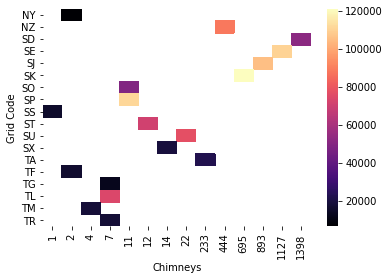

In [5]:
import pandas as pd
from OSGridConverter import latlong2grid

def grid_to_string(x):
    return x[0:2]

chimney_locations = get_locations("", chimney=True)
df  = pd.read_csv("crimes-and-gridcode-6months.csv")
df['Grid Code'] =df['Grid Code'].map(grid_to_string)

chim_df = pd.DataFrame(get_locations("", chimney=True), columns =['Longitude', 'Latitude'])

chimney_gridcodes =[]
for long,lat in chimney_locations:
    long = round(float(long),6)
    lat = round(float(lat),6)
    chimney_gridcodes.append(str(latlong2grid(lat,long)))


    
print(len(chimney_gridcodes))
print(chim_df.shape)
chim_df["Grid Code"] = chimney_gridcodes
chim_df["Grid Code"] = chim_df["Grid Code"].map(grid_to_string)



pivot = chim_df.pivot_table(index=["Grid Code"], aggfunc='size')
keys = pivot.keys()

'''
[[GridCode, Chimneys, Crimes, Crimes/Chimney Ratio]]

'''
print(pivot)
chimneys_and_crimes = []

print(len(pivot))
# for i in range(0,len(pivot)):
for i in range(0,len(pivot)):
    n_crimes = len(df.loc[df['Grid Code'] == keys[i]])
    if keys[i] == "TQ":
        continue
    chimneys_and_crimes.append([keys[i], pivot[i], n_crimes, n_crimes/pivot[i], n_crimes-pivot[i]])

    
crimes_to_chimney = pd.DataFrame(chimneys_and_crimes,columns =["Grid Code", "Chimneys", "Crimes", "Crimes/Chimney", "Crimes-Chimneys"])
print(crimes_to_chimney)


import seaborn as sns
%matplotlib inline

heatmap1_data = pd.pivot_table(crimes_to_chimney, values='Crimes', 
                     index=['Grid Code'], 
                     columns='Chimneys')
sns.heatmap(heatmap1_data, cmap="magma")


In [83]:
import numpy as np
from scipy import stats

print(crimes_to_chimney.sort_values(by=["Chimneys"]))
# high_chimney_crimes =
b=crimes_to_chimney.sort_values(by=["Chimneys"])

high_chimenys = b.loc[4:2,:]["Crimes"]
low_chimenys = b.loc[8:0,:]["Crimes"]

# print(high_chimenys)
var_a = high_chimenys.var(ddof=1)
var_b = low_chimenys.var(ddof=1)

s = np.sqrt((var_a + var_b)/2)
t = (high_chimenys.mean() - low_chimenys.mean())/(s*np.sqrt(2/3))

df = 2*3 - 2

p = 1 - stats.t.cdf(t,df=df)

print("t = " + str(t))
print("p = " + str(2*p))

# t2, p2 = stats.ttest_ind(high_chimenys,low_chimenys)
# print("t = " + str(t2))
# print("p = " + str(p2))

   Grid Code  Chimneys  Crimes  Crimes/Chimney  Crimes-Chimneys
8         SS         1   15789    15789.000000            15788
13        TF         2   16643     8321.500000            16641
0         NY         2    6518     3259.000000             6516
16        TM         4   18232     4558.000000            18228
14        TG         7   12672     1810.285714            12665
15        TL         7   74196    10599.428571            74189
17        TR         7   17829     2547.000000            17822
6         SO        11   49266     4478.727273            49255
7         SP        11  111627    10147.909091           111616
9         ST        12   71086     5923.833333            71074
11        SX        14   19302     1378.714286            19288
10        SU        22   77348     3515.818182            77326
12        TA       233   22553       96.793991            22320
1         NZ       444   88648      199.657658            88204
5         SK       695  121101      174.

Getting Map Files
Processing Map Files
Getting Map Files
Processing Map Files
20


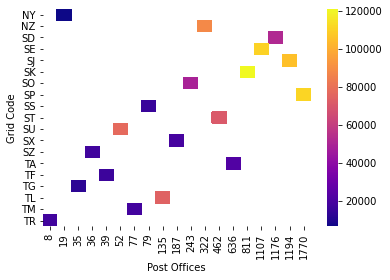

In [39]:
def grid_to_string(x):
    return x[0:2]

df  = pd.read_csv("crimes-and-gridcode-6months.csv")
df['Grid Code'] =df['Grid Code'].map(grid_to_string)

post_locations = get_locations("",chimney=False)
post_df = pd.DataFrame(get_locations("", chimney=False), columns =['Longitude', 'Latitude'])


post_gridcodes =[]
for long,lat in post_locations:
    long = round(float(long),6)
    lat = round(float(lat),6)
    post_gridcodes.append(str(latlong2grid(lat,long)))

post_df["Grid Code"] = post_gridcodes
post_df["Grid Code"] = post_df["Grid Code"].map(grid_to_string)

pivot_post = post_df.pivot_table(index=["Grid Code"], aggfunc='size')
keys = pivot_post.keys()

post_and_crimes = []

print(len(pivot_post))
# for i in range(0,len(pivot)):
for i in range(0,len(pivot_post)):
    n_crimes = len(df.loc[df['Grid Code'] == keys[i]])
    if keys[i] == "TQ":
        continue
    post_and_crimes.append([keys[i], pivot_post[i], n_crimes, n_crimes/pivot_post[i], n_crimes-pivot_post[i]])

crimes_to_post = pd.DataFrame(post_and_crimes,columns =["Grid Code", "Post Offices", "Crimes", "Crimes/Post Office", "Crimes-Post Offices"])

heatmap2_data = pd.pivot_table(crimes_to_post, values='Crimes', 
                     index=['Grid Code'], 
                     columns='Post Offices')
sns.heatmap(heatmap2_data, cmap="plasma")


In [75]:
import numpy as np
from scipy import stats

# print(crimes_to_post.sort_values(by=["Post Offices"]))
a = crimes_to_post.sort_values(by=["Post Offices"])
# print(a)
low_post =(a.loc[18:15,:]["Crimes"])
high_post =(a.loc[2:7,:]["Crimes"])

# high_chimenys = crimes_to_chimney.loc[2:4,:]["Crimes"]
# low_chimenys = crimes_to_chimney.loc[15:17,:]["Crimes"]

var_a = high_post.var(ddof=1)
var_b = low_post.var(ddof=1)

s = np.sqrt((var_a + var_b)/2)
t = (high_chimenys.mean() - low_chimenys.mean())/(s*np.sqrt(2/3))

df = 2*3 - 2

p = 1 - stats.t.cdf(t,df=df)

print("t = " + str(t))
print("p = " + str(2*p))

t = 2.726192188649925
p = 0.05264931055948918


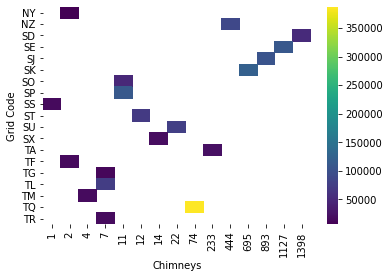

In [14]:
# print(len(chimneys_and_crimes))

crimes = pd.DataFrame(chimneys_and_crimes,columns =["Grid Code", "Chimneys", "Crimes", "Crimes/Chimney", "Crimes-Chimneys"])
# crimes.to_csv('crimes-chimneys-gridcodes.csv',index = False)


import seaborn as sns
%matplotlib inline

heatmap1_data = pd.pivot_table(crimes, values='Crimes', 
                     index=['Grid Code'], 
                     columns='Chimneys')
sns.heatmap(heatmap1_data, cmap="viridis")


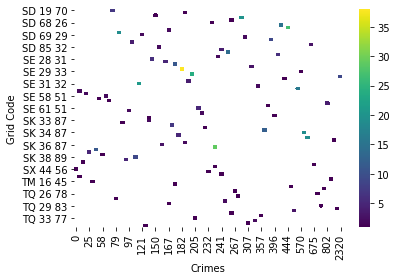

In [119]:
import seaborn as sns
%matplotlib inline
# sns.heatmap(crimes, cmap='RdYlGn_r', linewidths=0.5, annot=True)
# crimes.style.background_gradient(cmap='Blues')
heatmap1_data = pd.pivot_table(crimes, values='Chimneys', 
                     index=['Grid Code'], 
                     columns='Crimes')
sns.heatmap(heatmap1_data, cmap="viridis")

In [ ]:
import os  
import numpy as np  
import pandas as pd  
from math import cos, asin, sqrt  
import csv  
from pathlib import Path  
from timeit import default_timer as timer  
from datetime import datetime

def distance(lat1, lon1, lat2, lon2):  
    p = 0.017453292519943295  #Pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a)) #2*R*asin..

crime_data = pd.read_csv("crimes-and-gridcode-6months.csv")
boundaries = pd.read_csv("Local_Authority_Districts_(December_2017)_Boundaries_in_Great_Britain.csv")
boundaries.drop(boundaries.columns.difference(['lad17nm','long','lat']), 1, inplace=True)

def closest(lat, long, boundaries):
    distances = []
    for p in boundaries.iterrows():
        ap = {
            'name' : p[1][0],
            'lat' : lat,
            'long' : long,
            'distance' : distance(lat,long, p[1][2],p[1][1])
        }
        distances.append(ap)
    return sorted(distances, key=lambda k: k['distance'])[0]
    

# print(crime_data.values[0])
long, lat = crime_data.values[0][0],crime_data.values[0][1]
print(long,lat)

cities = []
for row in crime_data.iterrows():
    long ,lat= row[1][0], row[1][1]
#     print(long,lat)
    cities.append(closest(lat,long,boundaries)['name'])
# print(closest(lat,long,boundaries)['name'])

print(cities)

# for p in boundaries:
#     print(p)
# for row in crime_data.iterrows():
#     long ,lat= row[1][0], row[1][1]
#     for p in boundaries
#     print(distance)
# print(boundaries)

-2.03674 53.355936
